# SpecFANN Tutorial

## Introduction

SpecFANN (Spectroscopic Fitting via Artificial Neural Networks) is a deep learning based FASTWIND emulator and spectroscopic fitting suite written in Python.  Using a series of neural networks trained to emulate individual FASTWIND line profiles, SpecFANN allows the user to very quickly produce forward models for any subset of the ~140 included spectral lines, and allows the user to fit observed spectra using various minimization techniques and samplers. SpecFANN is also built in a flexible way such that if users have thier own trained neural networks, these can be dropped in to replace the provided networks, while still being able to use all of the framework set up here. For details on how the code works, please see the corresponding release paper: (coming soon)

## Getting started

In [1]:
# imports
import specfann
import numpy as np


SpecFANN can either be run directly in the git directory, or if the directory has been added to your Python path, it can be run from anywhere.  That said, I would recommend that you add any bundle to the bundles directory within the git directory as SpecFANN will look here for the bundles.  The default bundle (and only one currently available) is `MW_v1.0`, but in the future when other bundles are available (or if you have your own that you would like to use), you can specify the name of the bundle in the call to initiate specfann `bundle_name = 'alternative_bundle_name'`.  Otherwise, if your bundle is stored in a location that is not in the .../SpecFANN/bundles/ directory then you will need to specify the full path to the bundle using `bundle_path = 'path/to/bundle'`

In [2]:
# if you've added the MW_v1.0 bundle to the bundles directory, then the following three lines should do the exact same thing
s = specfann.specfann()
# s = specfann.specfann(bundle_name = 'MW_v1.0')
# s = specfann.specfann(bundle_path = '/home/michael/SpecFANN/bundles/MW_v1.0')


## Read in observed spectrum

To fit an observed spectrum, it must be uploaded using the `load_observed_data()` function where you can pass the wavelength, and flux arrays (and optionally the error array).  If only the wavelength and flux are passed, SpecFANN will calculate the error array based on the standard deviation of the observed flux data in the continuum and assign that value to all observed points.  If you pass the observed error array, make sure the array does not contain any nans as this will cause issues.

In [3]:
wavelength, flux = np.loadtxt('data/HD214680.txt').T
s.load_observed_data(wavelength, flux)
# s.load_observed_data(wavelength, flux, error)


## Setting the line list

The full available line list will depend on the specific bundle that you are using, but this can be found by calling the following function:

In [4]:
print(s.sbf.full_line_list())

['OIII5268', 'CII6151', 'CIII6744', 'HDELTA', 'HEII6406', 'HEI4922', 'NII4601', 'OV1371', 'NII5931', 'CIV5801', 'NIV1718', 'CII4267', 'SIIV4631', 'HEII4541', 'HGAMMA', 'NIV5205', 'CII5137', 'CII6787', 'CII3920', 'HALPHA', 'NII4041', 'CIII5696', 'SIIV6701', 'CII5662', 'NII4552', 'CII6462', 'CII5648', 'CII6780', 'CIII4162', 'HEI4009', 'CII6791', 'HEII4686', 'OIII5508', 'NIII3999', 'NIV6380', 'CIV5018', 'NII4447', 'CIII1247', 'CIII1176', 'CII1335', 'OIII5592', 'CIV1169', 'CII1324', 'HEI5875', 'OII4906', 'NII5710', 'CII1066', 'NVall', 'NIIIqua', 'HEII1640', 'NIII4523', 'CII5641', 'CII5133', 'CIII4650', 'HEII6527', 'CII6530', 'NII3995', 'HEI4387', 'CII5333', 'NIII4547', 'NIII4535', 'HEI4143', 'SIIV6667', 'OIII3961', 'CII7231', 'HEI4471', 'HEII4200', 'CII6801', 'OII441416', 'OII4941', 'HEII5411', 'OII3954', 'NIII4103', 'CII6582', 'CII5145', 'NII5007', 'HEI4026', 'NIII3355', 'NII6610', 'HEI4121', 'CIII4056', 'CII5890', 'OIV1340', 'CIII4070', 'CII1760', 'CIV1550', 'HEI4713', 'NIIItrip', 'CII51

To keep the computation time reasonable, we'll select a fairly small line list. To add a line, you need to call the `add_line()` function and specify one of the lines included in the full line list above.  Optionally, if you would like to alter the default fit ranges, you can pass `fit_range=[X, Y]` to specify the new range of your fit as shown below:

In [5]:
s.add_line('HDELTA')
s.add_line('HGAMMA')
s.add_line('HEI4471', fit_range=[4460, 4480])
s.add_line('HEII4541')
s.add_line('CII1036')

If you would like to remove a line, you can use the `remove_line()` function, passing the line name that you would like to remove

In [6]:
s.remove_line('CII1036')

You can check which lines you've included at any time by:

In [7]:
print(s.line_list.keys())

dict_keys(['HDELTA', 'HGAMMA', 'HEI4471', 'HEII4541'])


## Setting and modifying parameters

With the default bundle, 10 parameters are included (+1 for MCMC) in the parameter set, and a summary of their default values and fitting ranges can be found by calling `s.parameters.summary()`

In [8]:
s.parameters.summary()

Parameters:
teff: 40000 (fixed: False, bounds: [15000, 60000])
logg: 4.0 (fixed: False, bounds: [2.0, 4.5])
r: 7 (fixed: False, bounds: [5, 30])
he: 0.1 (fixed: False, bounds: [0.06, 0.3])
c: 7.5 (fixed: False, bounds: [6.0, 9.0])
n: 7.5 (fixed: False, bounds: [6.0, 9.0])
o: 7.5 (fixed: False, bounds: [6.0, 9.0])
si: 7.5 (fixed: False, bounds: [6.0, 9.0])
vrot: 0 (fixed: False, bounds: [0, 500])
gamma: 0 (fixed: False, bounds: [-500, 500])
logf: 0.0 (fixed: False, bounds: [-10, 10])


By default, all parameters are left free, but we can fix certain parameters to either their default value or some other specified value using the `fix` method.  If we pass a value, then the parameter will be fixed to the specified value, and if we leave it empty then it will be fixed to its default.

In [9]:
# since we are only including hydrogen and helium lines (and a blended nitrogen line in HDELTA), lets fix the C, O and Si abundances
s.parameters.c.fix()
s.parameters.o.fix()
s.parameters.si.fix()
# we'll also fix the radius and temporarily fix the temperature
s.parameters.r.fix(6)
s.parameters.teff.fix()

We can also free a parameter that we've previously fixed by using the `free` method:

In [10]:
s.parameters.teff.free()

We can also set new bounds by using the `set_bounds` method.  Lets change the bounds for the systemic velocity as it is rather wide for our specific system:

In [11]:
s.parameters.gamma.set_bounds([-200,200])

Lets take a look at how the parameter summary looks now

In [12]:
s.parameters.summary()

Parameters:
teff: 40000 (fixed: False, bounds: [15000, 60000])
logg: 4.0 (fixed: False, bounds: [2.0, 4.5])
r: 6 (fixed: True, bounds: [5, 30])
he: 0.1 (fixed: False, bounds: [0.06, 0.3])
c: 7.5 (fixed: True, bounds: [6.0, 9.0])
n: 7.5 (fixed: False, bounds: [6.0, 9.0])
o: 7.5 (fixed: True, bounds: [6.0, 9.0])
si: 7.5 (fixed: True, bounds: [6.0, 9.0])
vrot: 0 (fixed: False, bounds: [0, 500])
gamma: 0 (fixed: False, bounds: [-200, 200])
logf: 0.0 (fixed: False, bounds: [-10, 10])


## Fitting

3 different fitting/sampling methods are currently implemented into SpecFANN, however in the future others may be implemented as well.  For now these are Nelder Mead, Genetic Algorithm, and MCMC.  While a powerful fitter, Nelder Mead can sometimes fail if the initial guess is not close enough to the best fit solution. In general the GA allows you to efficiently explore the parameter space and find the best fit solution in a relatively short amount of time, so without any prior knowledge about the system, we would suggest that you start here.  Once you have found the best fit solution, MCMC can be used to sample the posterior distribution.  We'll focus on the GA and MCMC here.

### Genetic Algorithm

Here we use the pyGA package [(github repo)](https://github.com/MichaelAbdul-Masih/pyGA) to handle all of the genetic algorithm specific functions.  Running the GA within SpecFANN can be done by calling the `run_GA()` function, where you can specify the number of generations (equivalent to number of iterations) and the population size (equivalent to number of walkers).  For our current example, this setup takes ~3 minutes on my local machine so it should be more or less similar for you.  Also, do not be alarmed about the warning, this is specific to one of the included packages and will always happen upon the first call to the neural net. 

In [13]:
s.run_GA(n_generations=300, population_size=50)

GA generations:   0%|                                   | 0/300 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1755702225.233843 2883122 service.cc:148] XLA service 0x74c99c007a40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755702225.233942 2883122 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1755702225.323908 2883122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GA generations: 100%|█████████████████████████| 300/300 [03:08<00:00,  1.59it/s]


Once the GA has finished running, we can take a look ag the results.  Using the `plot_GA_fit()` command, you can overplot the GA results on top of the observed spectrum.  The observed spectrum is plotted in black and the best fit GA solution is plotted as a red line.  All solutions that fall within the 2 sigma confidence interval are represented by the lighter red region, representing the error on the fit.

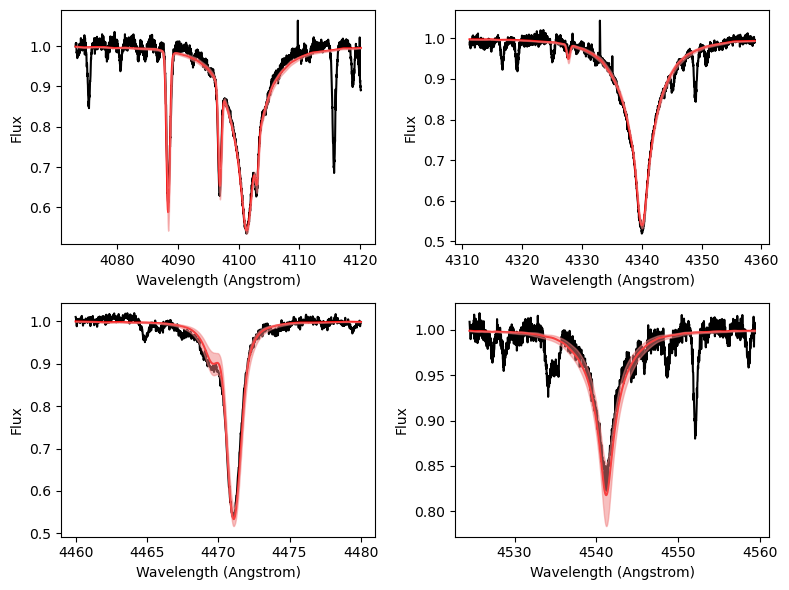

In [14]:
s.plot_GA_fit()

We can also plot the GA diagnostic plots which show each parameter as a function of the fitness.  The red highlighted region represents the 2 sigma error bar (also indicated in text above each subplot) and the fill color of each point represents the generation with darker colors representing earlier generations and lighter colors representing later generations.

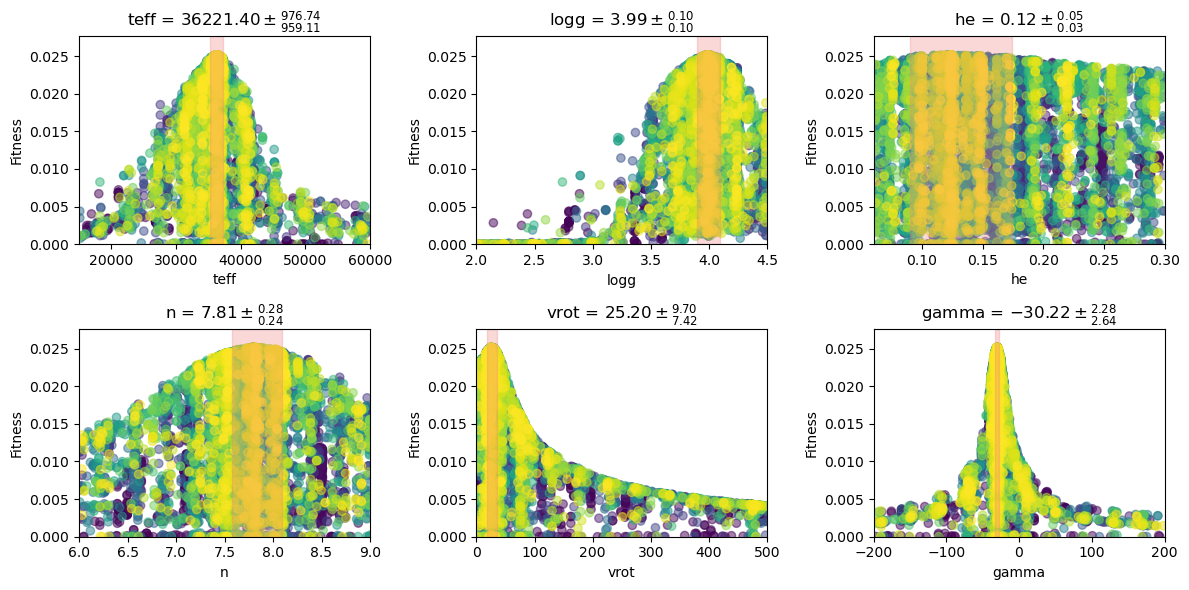

In [15]:
s.plot_GA_results()

Finally, we can output the results of the GA in plain text using the `print_GA_results()` function:

In [16]:
s.print_GA_results()

GA Results Summary:
        teff =  36221.4  ( +976.740; -959.115)
        logg =  3.98972  ( +0.102; -0.097)
          he =  0.123972  ( +0.050; -0.034)
           n =  7.81208  ( +0.281; -0.240)
        vrot =  25.196  ( +9.699; -7.416)
       gamma =  -30.219  ( +2.276; -2.640)
Best fitness: 0.02513357563415804
Number of generations: 300
Population size: 50


### MCMC

Here we use the emcee package [(webpage)](https://emcee.readthedocs.io/en/stable/).  Running MCMC within SpecFANN can be done by calling the `run_mcmc()` function and it uses very similar arguements to the GA, but the syntax is slightly different.  Here we define the number of walkers using `n_walkers` and the number of interations with `n_steps`.  Since MCMC is meant to sample the posterior parameter space, we'll use the best fit GA model as the initial position for MCMC to start from.  This can be done as follows.  Given the significantly higher number if iterations, this will take quite a bit longer than the GA run (on my machine this took ~1 hour)

In [17]:
s.run_mcmc(initial_positions=s.GA_results.best_fit_model, n_walkers=50, n_steps=5000)

100%|█████████████████████████████████████| 5000/5000 [1:05:00<00:00,  1.28it/s]


Similar to the GA, we have convenience functions implemented to plot the MCMC results and fit to the observed spectra.  Before looking at the fit, lets first check how the trace plots and posterior distributions look to see if we've converged. We can set the burnin and thinning in the function call.

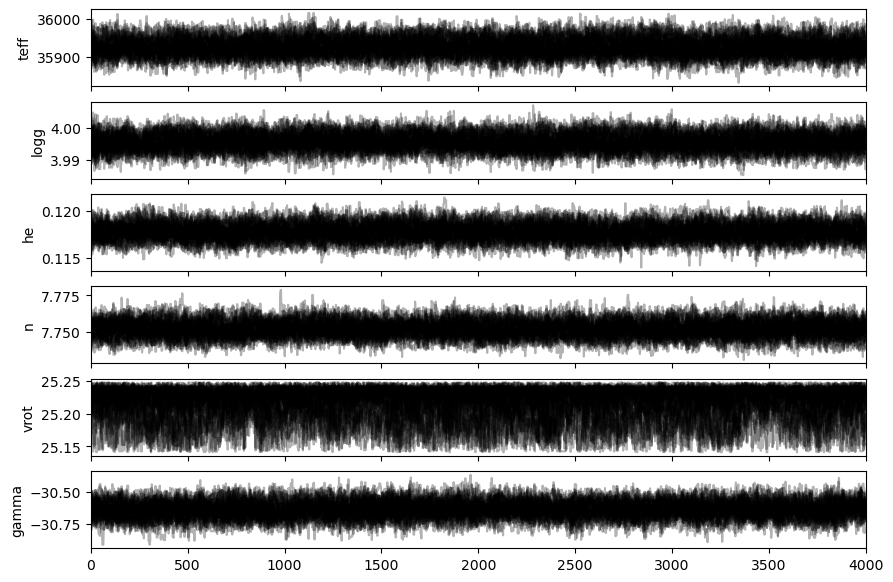

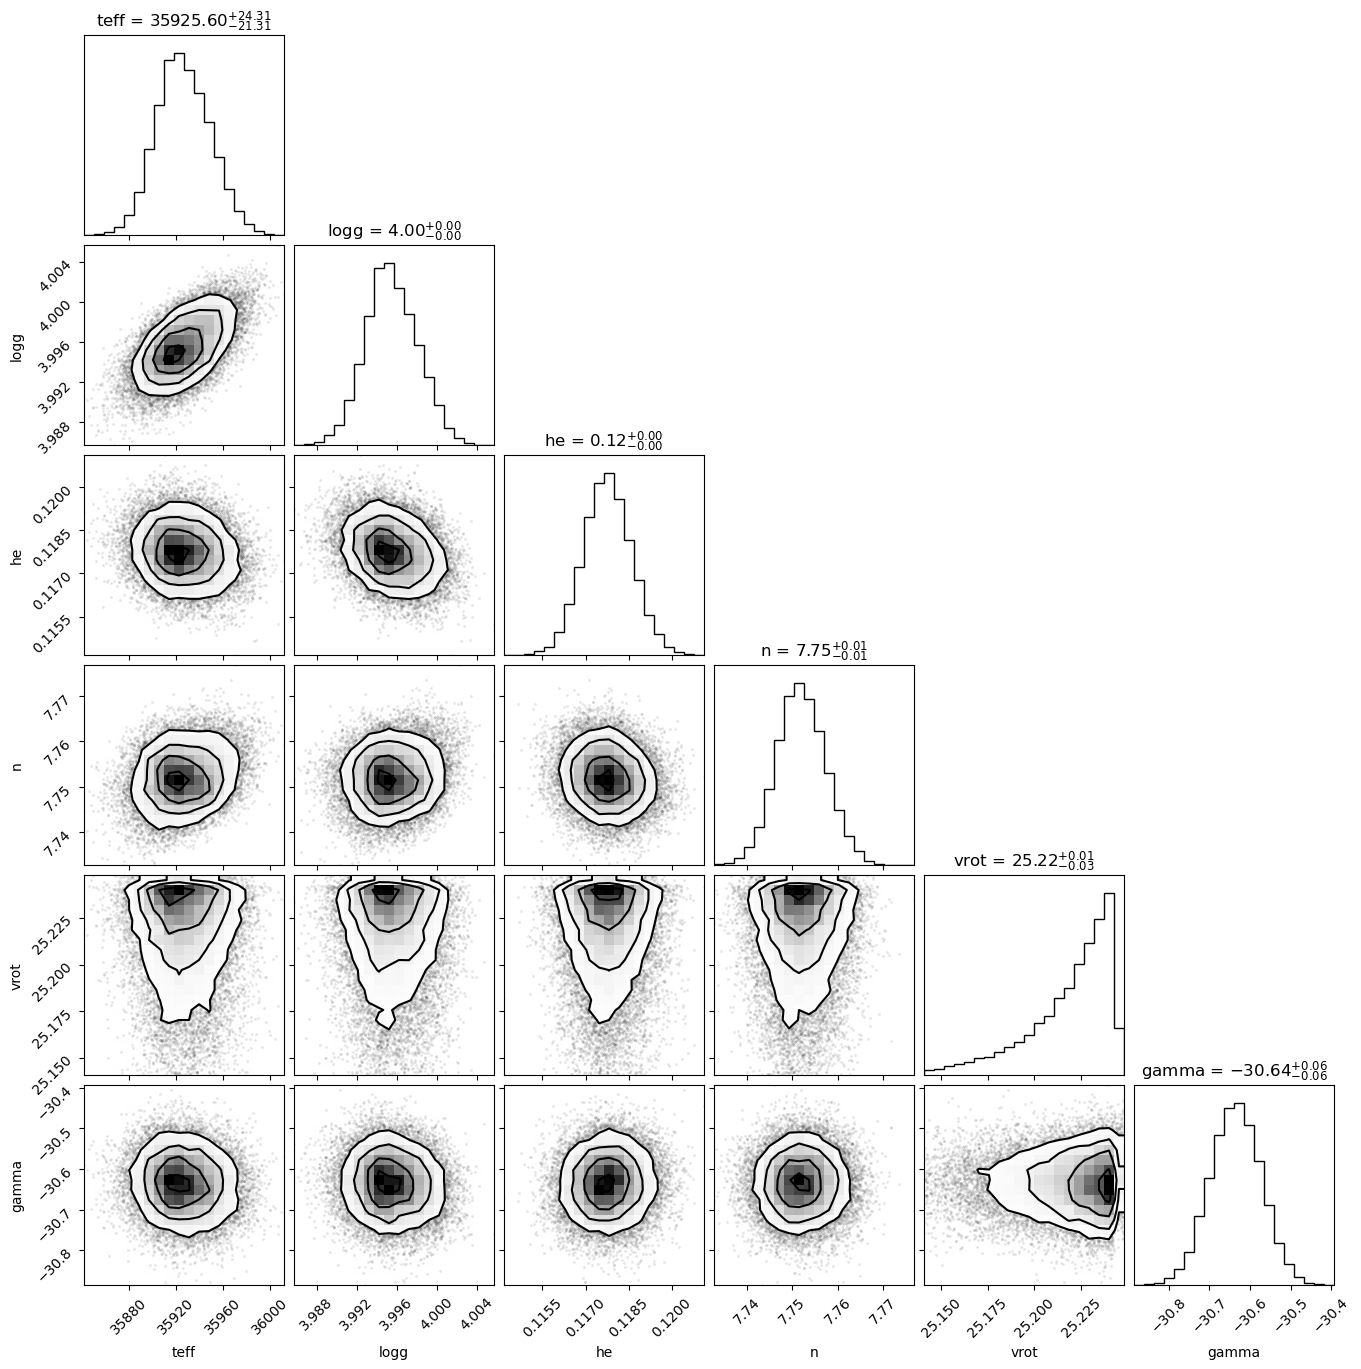

In [18]:
s.plot_MCMC_results(burnin=1000, thin=10)

(following the same color scheme as above, however in the case of MCMC, 1 sigma errors are plotted).  Here we can specify the burnin to avoid the initial iterations before the solution has settled.

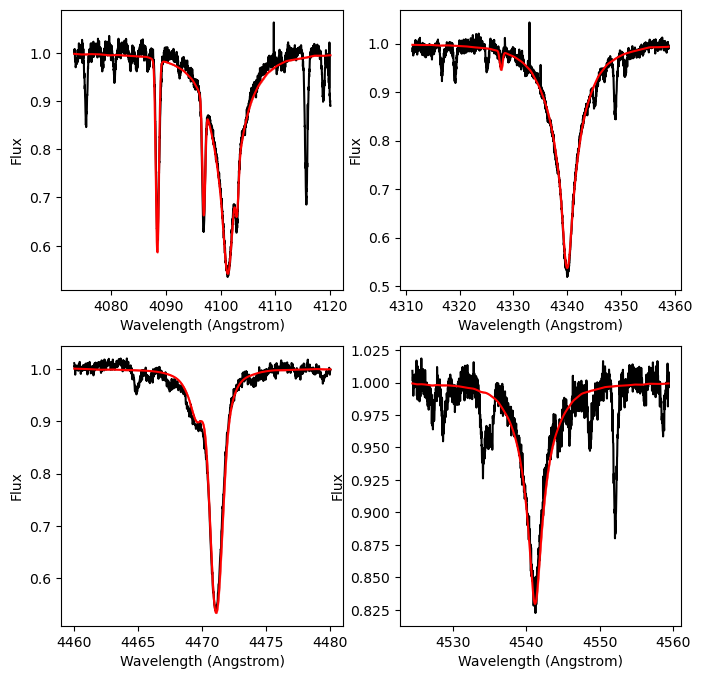

In [19]:
s.plot_MCMC_fit(burnin=1000)

Like with the GA, we can also print out the results of the MCMC run using the `print_MCMC_results()` function

In [20]:
s.print_MCMC_results(burnin=1000)

MCMC Results:
        teff =  35925.57158748944  ( +24.29045; -21.34088)
        logg =  3.995391720119587  ( +0.00277; -0.00241)
          he =  0.11775155673399443  ( +0.00085; -0.00082)
           n =  7.751820849903149  ( +0.00545; -0.00516)
        vrot =  25.225006861005603  ( +0.01395; -0.02891)
       gamma =  -30.635469875447054  ( +0.06237; -0.06248)
Number of iterations: 5000
Number of walkers: 50


## Saving and loading SpecFANN results

If you want to save the current state of your SpecFANN instance, you can use the `save()` function by passing the name of file that you want to save your results to. These can be later loaded in using the `specfann.open_project()` function, and then you will be able to pick up exactly where you left off, and all of your settings and fitting results will be available.

In [21]:
# save results
s.save('results.specfann')

# load results
s = specfann.open_project('results.specfann')


## Simulating synthetic spectral lines without fitting

While SpecFANN is built primarily for fitting observed spectra, we can just its synthesis capabilities without needing observed spectra.  As an example, lets simulate a binary system.  We'll start with a fresh SpecFANN instance and add in a few spectral lines to simulate:

In [22]:
s = specfann.specfann()

s.add_line('HDELTA')
s.add_line('HGAMMA')
s.add_line('HEI4026')
s.add_line('HEI4143')
s.add_line('HEI4387')
s.add_line('HEI4471')
s.add_line('HEII4200')
s.add_line('HEII4541')
s.add_line('HEII4686')
s.add_line('CIII4186')
s.add_line('CIII4650')
s.add_line('NIII4379')
s.add_line('NIIIqua')
s.add_line('NIIItrip')
s.add_line('NIV4058')
s.add_line('OIII5592')


Lets remind ourselves of the parameter set that we are working with and its order, and then we can create two arrays (one for each star in our system) which contains the values that we want to correspond to each of the parameters.  In this case, we'll set different gammas for each component to simulate radial velocity shifts due to the orbit.

In [23]:
s.parameters.summary()

Parameters:
teff: 40000 (fixed: False, bounds: [15000, 60000])
logg: 4.0 (fixed: False, bounds: [2.0, 4.5])
r: 7 (fixed: False, bounds: [5, 30])
he: 0.1 (fixed: False, bounds: [0.06, 0.3])
c: 7.5 (fixed: False, bounds: [6.0, 9.0])
n: 7.5 (fixed: False, bounds: [6.0, 9.0])
o: 7.5 (fixed: False, bounds: [6.0, 9.0])
si: 7.5 (fixed: False, bounds: [6.0, 9.0])
vrot: 0 (fixed: False, bounds: [0, 500])
gamma: 0 (fixed: False, bounds: [-500, 500])
logf: 0.0 (fixed: False, bounds: [-10, 10])


In [24]:
# star = [teff, logg, raidus, he, c, n, o, si, vrot, gamma, logf]
star1 = [40000, 4.0, 7.0, 0.15, 7.5, 8.5, 7.5, 7.5, 150, -100, 0.0]
star2 = [35000, 4.0, 6.0, 0.1, 7.5, 7.5, 7.5, 7.5, 60, 200, 0.0]

These parameters can be packed together and passed to the `generate_model()` function.  Here you can pass either a single parameter set (corresponding to one star) or you can pass an array of parameter sets.

In [25]:
models = s.generate_model(np.array([star1, star2]))
# model = s.generate_model(star1)     # this would also work if you just wanted to simulate one star

The models returned by `s.generate_model()` is a dictionary of dictionaries.  At the top level, models is a dictionary of the lines in your line list, and each line is a dictionary that contains a 'wavelengths' and a 'fluxes' key.  In other words, if you wanted the wavelength array of the HeI4471 line for star1, you would call this using `models['HEI4471']['wavelengths'][0]` and for star2 it would be `models['HEI4471']['wavelengths'][1]`.  Lets plot the HeI4471 line for both components:

In [26]:
import matplotlib.pyplot as plt
%matplotlib ipympl

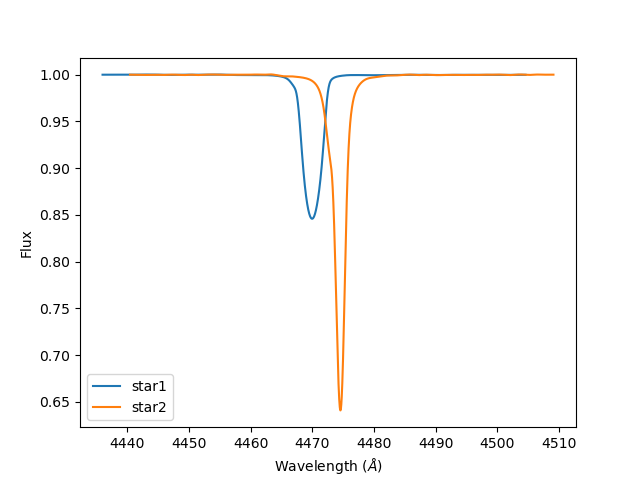

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(models['HEI4471']['wavelengths'][0], models['HEI4471']['fluxes'][0], label = 'star1')
plt.plot(models['HEI4471']['wavelengths'][1], models['HEI4471']['fluxes'][1], label = 'star2')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.legend(loc='best')
plt.show()

Now lets creat a mock spectrum for both components, assign a light ratio and combine them:

In [28]:
# create common wavelength array
wavelength = np.linspace(4000, 5000, 100001)

# build flux array for each component
flux_star1 = np.ones_like(wavelength)
flux_star2 = np.ones_like(wavelength)
for line in models.keys():
    w1 = models[line]['wavelengths'][0]
    f1 = models[line]['fluxes'][0]
    flux_star1 *= np.interp(wavelength, w1, f1, right=1, left=1)

    w2 = models[line]['wavelengths'][1]
    f2 = models[line]['fluxes'][1]
    flux_star2 *= np.interp(wavelength, w2, f2, right=1, left=1)

   

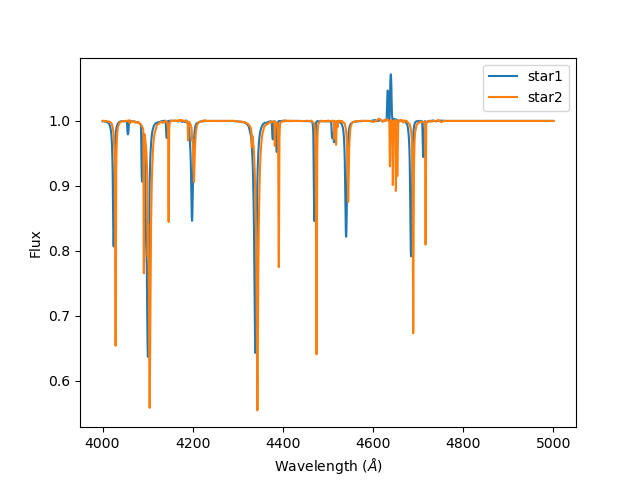

In [29]:
# lets plot to see how things look
fig, ax = plt.subplots()
plt.plot(wavelength, flux_star1, label='star1')
plt.plot(wavelength, flux_star2, label='star2')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.legend(loc='best')
plt.show()

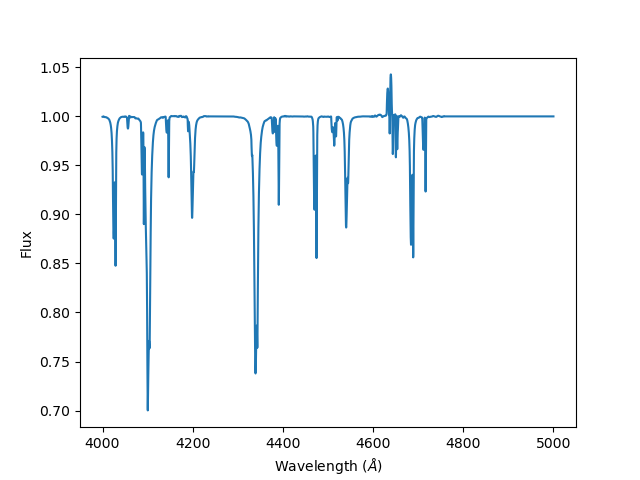

In [30]:
# combine the two assuming star1's light ratio is 0.6
lr1 = 0.6
lr2 = 1-lr1

flux = flux_star1 * lr1 + flux_star2 * lr2

# and lets plot the result
fig, ax = plt.subplots()
plt.plot(wavelength, flux)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.show()